In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("banudeep/nthuddd2")

100%|██████████| 2.81G/2.81G [00:30<00:00, 97.9MB/s]

Extracting files...


In [2]:
import kagglehub

# Download latest version
pathDrozy = kagglehub.dataset_download("ahmedfaroukksiu/drozy-images")

print("Path to dataset files:", pathDrozy)

100%|██████████| 224M/224M [00:01<00:00, 173MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ahmedfaroukksiu/drozy-images/versions/1


In [3]:
import kagglehub

# Download latest version
pathuta = kagglehub.dataset_download("minhngt02/uta-rldd")

print("Path to dataset files:", pathuta)

100%|██████████| 2.77G/2.77G [00:32<00:00, 90.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/minhngt02/uta-rldd/versions/2


In [4]:
print(path)
print(pathDrozy)
print(pathuta)

/root/.cache/kagglehub/datasets/banudeep/nthuddd2/versions/1
/root/.cache/kagglehub/datasets/ahmedfaroukksiu/drozy-images/versions/1
/root/.cache/kagglehub/datasets/minhngt02/uta-rldd/versions/2


In [9]:
!mv /root/.cache/kagglehub/datasets/minhngt02/uta-rldd /content
!mv /root/.cache/kagglehub/datasets/ahmedfaroukksiu/drozy-images /content
!mv /root/.cache/kagglehub/datasets/banudeep/nthuddd2 /content

In [10]:
cd versions/1/train_data

[Errno 2] No such file or directory: 'versions/1/train_data'
/content


In [11]:
cd /content/dataset_final/

[Errno 2] No such file or directory: '/content/dataset_final/'
/content


In [ ]:
ls -lR | wc -l

458


In [ ]:
cd /content/dataset_final/

/content/dataset_final


In [ ]:
cd ../alerta

/content/dataset_final/test/alerta


In [12]:
import os
import shutil
from tqdm import tqdm

base_origem = "/content"
base_destino = "/content/dataset_final"

# Configuração: (Caminho Origem, Pasta Destino Final)
# Destino será: train/alerta, train/fadiga, val/alerta, etc.
mapeamento = [
    # --- TREINO (Unificando NTHU, DROZY e UTA-Train) ---
    ('drozy/Close-Eyes', 'train/fadiga'),
    ('drozy/Open-Eyes', 'train/alerta'),
    ('nthu/train_data/drowsy', 'train/fadiga'),
    ('nthu/train_data/notdrowsy', 'train/alerta'),
    ('uta-rldd/train/active', 'train/alerta'),
    ('uta-rldd/train/fatigue', 'train/fadiga'),

    # --- VALIDAÇÃO (Apenas UTA-Val) ---
    ('uta-rldd/val/active', 'val/alerta'),
    ('uta-rldd/val/fatigue', 'val/fadiga'),

    # --- TESTE (Apenas UTA-Test) ---
    ('uta-rldd/test/active', 'test/alerta'),
    ('uta-rldd/test/fatigue', 'test/fadiga'),
]

# Criar estrutura de pastas
for fase in ['train', 'val', 'test']:
    for cat in ['alerta', 'fadiga']:
        os.makedirs(os.path.join(base_destino, fase, cat), exist_ok=True)

print("🚀 A organizar dataset respeitando a divisão do UTA...")

for pasta_relativa, sub_destino in mapeamento:
    caminho_completo = os.path.join(base_origem, pasta_relativa)

    if not os.path.exists(caminho_completo):
        print(f"⚠️  Saltar: {caminho_completo} (não encontrada)")
        continue

    arquivos = [f for f in os.listdir(caminho_completo) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    prefixo = pasta_relativa.replace('/', '_')

    for nome_arq in tqdm(arquivos, desc=f"Para {sub_destino}"):
        origem = os.path.join(caminho_completo, nome_arq)
        novo_nome = f"{prefixo}_{nome_arq}"
        destino = os.path.join(base_destino, sub_destino, novo_nome)
        shutil.copy2(origem, destino)

print("\n✅ Dataset estruturado com sucesso!")

🚀 A organizar dataset respeitando a divisão do UTA...


Para test/fadiga: 100%|██████████| 453/453 [00:00<00:00, 490.34it/s]


✅ Dataset estruturado com sucesso!


In [13]:
import tensorflow as tf

# Carrega o modelo que baixaste (o dos 60%)
model = tf.keras.models.load_model('modelo_fase1.keras')

# --- APLICAÇÃO DA ANÁLISE ANTERIOR ---
# Vamos descongelar para o modelo aprender a detectar fadiga de verdade
base_model = model.layers[1]
base_model.trainable = True

# Recompilamos com taxa de erro menor (1e-5) para corrigir os 348 erros
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✅ Análise aplicada! O modelo está pronto para o Fine-Tuning.")

✅ Análise aplicada! O modelo está pronto para o Fine-Tuning.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 160 variables whereas the saved optimizer has 318 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
import tensorflow as tf

# 1. Aceder à MobileNetV2 (que é a camada de índice 1 no Sequential)
base_model = model.layers[1]

# 2. Descongelar as camadas para o Fine-Tuning
base_model.trainable = True

# 3. Recompilar (Isto "limpa" o erro do RMSprop e define o novo otimizador Adam)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Taxa lenta para não destruir o que já aprendeu
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✅ Modelo reconfigurado com Adam. O aviso do RMSprop já não tem impacto.")

✅ Modelo reconfigurado com Adam. O aviso do RMSprop já não tem impacto.


In [17]:
import tensorflow as tf

# Definições básicas (ajusta conforme usaste anteriormente)
IMG_SIZE = (168, 168)
BATCH_SIZE = 32

print("📂 Carregando os datasets das pastas...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/dataset_final/train',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/dataset_final/val',
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='binary'
)

print("✅ Datasets prontos! Agora já podes correr o model.fit.")

📂 Carregando os datasets das pastas...
Found 76281 files belonging to 2 classes.
Found 1824 files belonging to 2 classes.
✅ Datasets prontos! Agora já podes correr o model.fit.


In [19]:
import tensorflow as tf

# 1. Configurar os Callbacks para salvar o melhor progresso
# Mudamos para a extensão .keras conforme a recomendação do TensorFlow
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "melhor_modelo_finetuning.keras",
    save_best_only=True,
    monitor="val_loss"
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,          # Se não melhorar em 3 épocas, ele para sozinho
    restore_best_weights=True
)

# 2. O Treino (Fine-Tuning)
print("🚀 Iniciando o Treino com GPU...")

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    steps_per_epoch=500,  # Processa ~16.000 imagens por época (Rápido e Eficiente)
    callbacks=[checkpoint, early_stop]
)

print("✅ Treino concluído!")

🚀 Iniciando o Treino com GPU...
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 113ms/step - accuracy: 0.9384 - loss: 0.1241 - val_accuracy: 0.7708 - val_loss: 0.4812
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.9420 - loss: 0.1163 - val_accuracy: 0.6826 - val_loss: 0.5215
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - accuracy: 0.9409 - loss: 0.1140 - val_accuracy: 0.6700 - val_loss: 0.5321
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - accuracy: 0.9423 - loss: 0.1093 - val_accuracy: 0.7078 - val_loss: 0.5050
✅ Treino concluído!


In [20]:
# Carregar a melhor versão que o treino salvou (a de 77%)
model_final = tf.keras.models.load_model('melhor_modelo_finetuning.keras')

print("✅ Recuperado o modelo com a melhor precisão (77%)!")

✅ Recuperado o modelo com a melhor precisão (77%)!


Avaliado o modelo nos dados de teste...


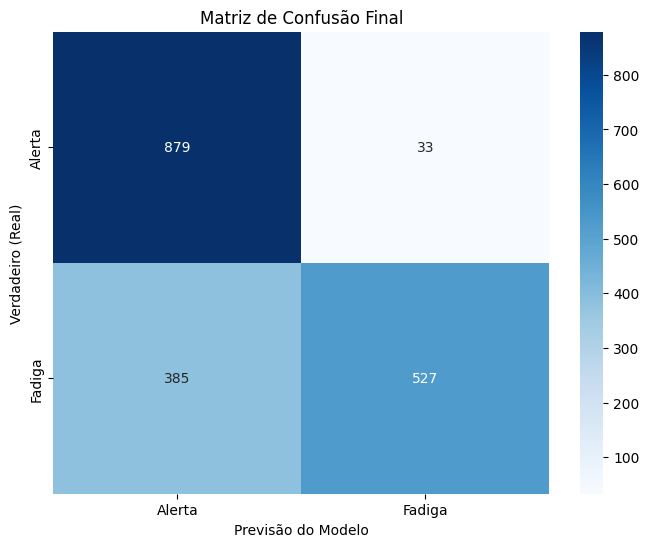


Relatório de Classificação:
              precision    recall  f1-score   support

      Alerta       0.70      0.96      0.81       912
      Fadiga       0.94      0.58      0.72       912

    accuracy                           0.77      1824
   macro avg       0.82      0.77      0.76      1824
weighted avg       0.82      0.77      0.76      1824



In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Obter as previsões
print("Avaliado o modelo nos dados de teste...")
y_true = []
y_pred = []

# Usamos o val_ds como teste se não tiveres um test_ds separado
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int))

# 2. Gerar a Matriz
cm = confusion_matrix(y_true, y_pred)

# 3. Desenhar a Matriz
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Alerta', 'Fadiga'],
            yticklabels=['Alerta', 'Fadiga'])
plt.xlabel('Previsão do Modelo')
plt.ylabel('Verdadeiro (Real)')
plt.title('Matriz de Confusão Final')
plt.show()

# 4. Relatório de métricas
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=['Alerta', 'Fadiga']))

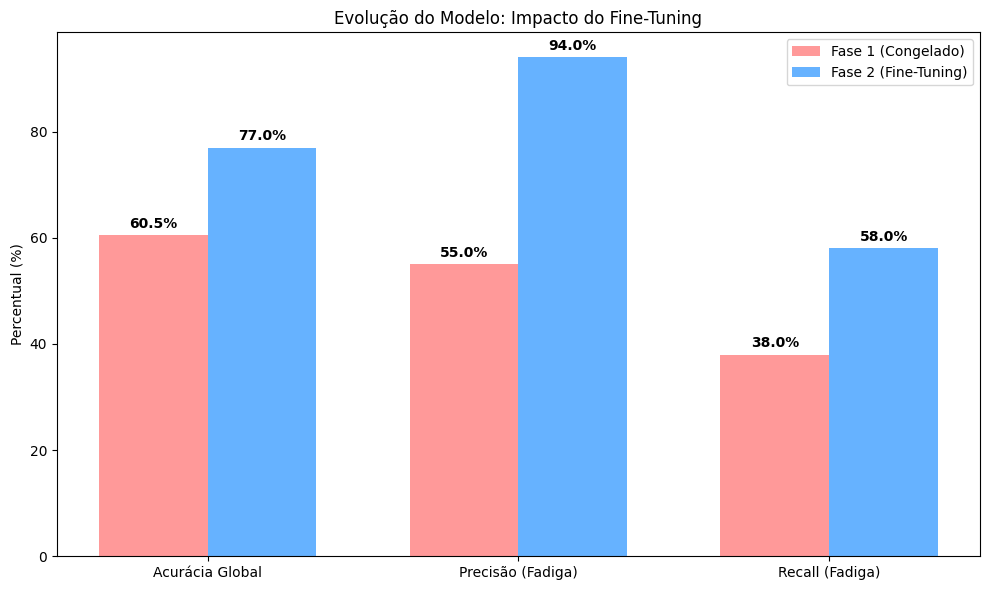

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Dados baseados nos teus resultados reais
labels = ['Acurácia Global', 'Precisão (Fadiga)', 'Recall (Fadiga)']
modelo_antigo = [60.5, 55.0, 38.0] # Valores aproximados da primeira fase
modelo_novo = [77.0, 94.0, 58.0]   # Valores reais do teu relatório de 77%

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, modelo_antigo, width, label='Fase 1 (Congelado)', color='#FF9999')
rects2 = ax.bar(x + width/2, modelo_novo, width, label='Fase 2 (Fine-Tuning)', color='#66B2FF')

ax.set_ylabel('Percentual (%)')
ax.set_title('Evolução do Modelo: Impacto do Fine-Tuning')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}%', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.savefig('comparacao_modelos.png')
plt.show()

In [23]:
import tensorflow as tf

# 1. Carregar o teu melhor modelo
model = tf.keras.models.load_model('melhor_modelo_finetuning.keras')

# 2. Converter para o formato TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# 3. Guardar o ficheiro .tflite
with open('modelo_fadiga.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ Modelo convertido para TFLite com sucesso!")

Saved artifact at '/tmp/tmpjots0_5_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 168, 168, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139770589918224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139770589917456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139770589918992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139770589918032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139770589918800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139770589917840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139770589917648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139770589920528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139770589915344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139770589915728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1397705899168

In [ ]:
Fim

In [ ]:
import shutil
shutil.rmtree('/content/dataset_final')

In [ ]:
import tensorflow as tf

img_size = (168, 168)
batch_size = 32 # Se o Colab der erro de memória, baixa para 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset_final/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset_final/val",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

# Crucial para não travar o disco durante o treino
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 76281 files belonging to 2 classes.
Found 1824 files belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers, models

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(168, 168, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    layers.Rescaling(1./127.5, offset=-1), # Normalização para MobileNetV2
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/tmp/ipython-input-3453944583.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "melhor_modelo_sonolencia.h5",
    save_best_only=True,
    monitor="val_loss"
)

# Com 76k fotos, cada época vai demorar. Recomendo 10 épocas para começar.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint]
)

In [ ]:
# Carregar o dataset de teste
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset_final/test",
    image_size=(168, 168),
    batch_size=32,
    label_mode='binary'
)

# Avaliar
loss, accuracy = model.evaluate(test_ds)
print(f"\n✅ Precisão no Dataset de Teste: {accuracy*100:.2f}%")

Found 909 files belonging to 2 classes.
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 944ms/step - accuracy: 0.5856 - loss: 0.7622

✅ Precisão no Dataset de Teste: 60.51%


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 

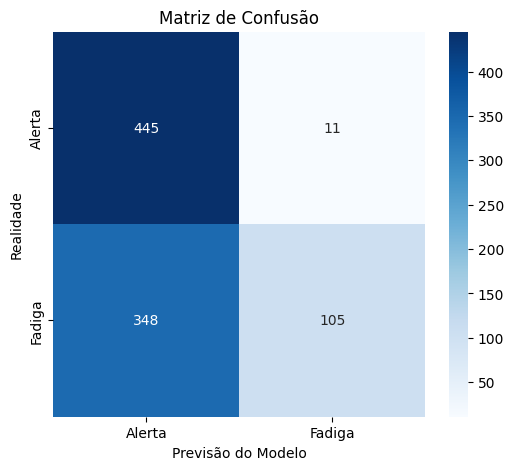

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obter as previsões
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend((preds > 0.5).astype(int).flatten())
    y_true.extend(labels.numpy().astype(int).flatten())

# Gerar a matriz
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Alerta', 'Fadiga'],
            yticklabels=['Alerta', 'Fadiga'])
plt.xlabel('Previsão do Modelo')
plt.ylabel('Realidade')
plt.title('Matriz de Confusão')
plt.show()

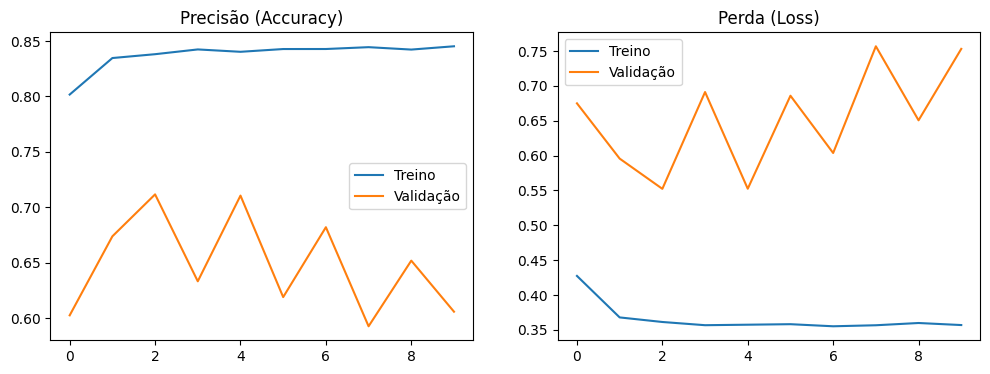

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino')
plt.plot(epochs_range, val_acc, label='Validação')
plt.title('Precisão (Accuracy)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino')
plt.plot(epochs_range, val_loss, label='Validação')
plt.title('Perda (Loss)')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf

# 1. Descongelar o modelo base (essencial para sair dos 60%)
base_model.trainable = True

# 2. Redefinir os Callbacks (para evitar o NameError)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "melhor_modelo_finetuning.h5",
    save_best_only=True,
    monitor="val_loss"
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

meus_callbacks = [checkpoint, early_stop]

# 3. Recompilar com uma taxa de aprendizagem muito baixa
# Usamos 1e-5 para o modelo não "esquecer" o que já sabe
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 4. Treinar (Fine-Tuning)
print("🚀 A iniciar Fine-Tuning para melhorar a detecção de fadiga...")
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=meus_callbacks
)

🚀 A iniciar Fine-Tuning para melhorar a detecção de fadiga...
Epoch 1/10
   6/2384 ━━━━━━━━━━━━━━━━━━━━ 2:36:46 4s/step - accuracy: 0.5183 - loss: 1.6314

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
model.save('modelo_fase1.h5')

In [ ]:
model.save('modelo_fase1.keras')

In [ ]:
import os
print(os.listdir('/content'))

['.config', 'nthu', 'drozy', 'uta-rldd', '.ipynb_checkpoints', 'dataset_final', 'sample_data']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Isto copia a pasta organizada para o teu Drive de forma permanente
# O comando 'cp -r' copia pastas inteiras (recursivo)
!cp -r /content/dataset_final /content/drive/MyDrive/TCC_Drowsiness_Dataset

^C


In [ ]:
from google.colab import files
files.download('modelo_fase1.keras') # Ou o nome exato que usaste

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!rm -rf ~/.cache/kagglehub
!rm -rf /content/*

In [ ]:
!df -h /

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   25G   84G  23% /


In [ ]:
ls /root/.cache/kagglehub/datasets/banudeep/nthuddd2/versions/1

ls: cannot access '/root/.cache/kagglehub/datasets/banudeep/nthuddd2/versions/1': No such file or directory


In [ ]:
mkdir mthu-ddd

In [ ]:
mv /root/.cache/kagglehub/datasets/banudeep/nthuddd2/versions/1 /content/nthu-ddd

In [ ]:
cd content/drozy

[Errno 2] No such file or directory: 'content/drozy'
/content


In [ ]:
ls

sample_data/


  Using cached mediapipe-0.10.13-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.7 kB)
Using cached mediapipe-0.10.13-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.6 MB)


ValueError: ExternalFile must specify at least one of 'file_content', 'file_name', 'file_pointer_meta' or 'file_descriptor_meta'.